In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [4]:
data_dir

'/Users/bakshiguptad/.keras/datasets/cora'

In [5]:
!ls /Users/bakshiguptad/.keras/datasets/cora

README       cora.cites   cora.content


In [6]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


In [7]:
citations.sample(frac=1).head()

,target,source
4152,133563,105856
3883,94639,593942
3558,70442,1107215
5209,643221,642894
1646,9586,33818


In [10]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [8]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [9]:
column_names[1]

'term_0'

In [10]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


In [11]:
class_values = sorted(papers["subject"].unique())

In [12]:
class_values

['Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory']

In [13]:
class_idx = {name: id for id, name in enumerate(class_values)}

In [14]:
class_idx

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [15]:
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [16]:
papers["paper_id"]

0         31336
1       1061127
2       1106406
3         13195
4         37879
         ...   
2703    1128975
2704    1128977
2705    1128978
2706     117328
2707      24043
Name: paper_id, Length: 2708, dtype: int64

In [17]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [25]:
#papers["paper_id"]

In [18]:
#citations["source"]

In [18]:
plt.figure(figsize=(10, 10))
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])

<Figure size 720x720 with 0 Axes>

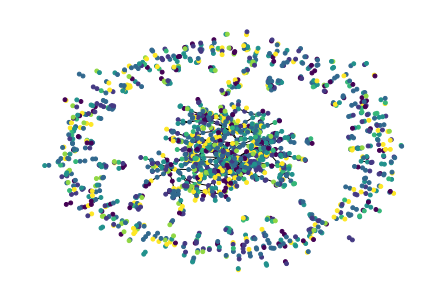

In [19]:
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [20]:
papers["subject"]

0       2
1       5
2       4
3       4
4       3
       ..
2703    1
2704    1
2705    1
2706    0
2707    2
Name: subject, Length: 2708, dtype: int64

In [42]:
#

In [21]:
train_data, test_data = [], []
i = 0
for groupIndex, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])
    #i= i+1
    print("groupIndex:",groupIndex)

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

groupIndex: 0
groupIndex: 1
groupIndex: 2
groupIndex: 3
groupIndex: 4
groupIndex: 5
groupIndex: 6
Train data shape: (1349, 1435)
Test data shape: (1359, 1435)


In [22]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [23]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [24]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [25]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [26]:
feature_names = set(papers.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_52806/3641831727.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_52806/3641831727.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [27]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

2022-08-18 15:12:33.965636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 1433)]       0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           52804       ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [28]:
# train baseline classifier
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/300
5/5 [==============================] - 4s 111ms/step - loss: 3.2868 - acc: 0.1789 - val_loss: 1.8457 - val_acc: 0.3941
Epoch 2/300
5/5 [==============================] - 0s 21ms/step - loss: 2.6226 - acc: 0.2426 - val_loss: 1.8573 - val_acc: 0.2118
Epoch 3/300
5/5 [==============================] - 0s 21ms/step - loss: 2.1750 - acc: 0.2461 - val_loss: 1.8934 - val_acc: 0.1232
Epoch 4/300
5/5 [==============================] - 0s 16ms/step - loss: 2.0418 - acc: 0.2644 - val_loss: 1.8602 - val_acc: 0.2217
Epoch 5/300
5/5 [==============================] - 0s 49ms/step - loss: 1.9621 - acc: 0.2792 - val_loss: 1.8260 - val_acc: 0.4384
Epoch 6/300
5/5 [==============================] - 0s 28ms/step - loss: 1.8758 - acc: 0.3072 - val_loss: 1.8086 - val_acc: 0.4926
Epoch 7/300
5/5 [==============================] - 0s 17ms/step - loss: 1.7698 - acc: 0.3333 - val_loss: 1.8103 - val_acc: 0.3596
Epoch 8/300
5/5 [==============================] - 0s 17ms/step - loss: 1.7217 - acc: 0.3

5/5 [==============================] - 0s 17ms/step - loss: 0.4274 - acc: 0.8569 - val_loss: 0.6363 - val_acc: 0.7980
Epoch 64/300
5/5 [==============================] - 0s 15ms/step - loss: 0.4404 - acc: 0.8386 - val_loss: 0.6297 - val_acc: 0.7980
Epoch 65/300
5/5 [==============================] - 0s 15ms/step - loss: 0.3972 - acc: 0.8525 - val_loss: 0.6327 - val_acc: 0.7931
Epoch 66/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4073 - acc: 0.8551 - val_loss: 0.6499 - val_acc: 0.7882
Epoch 67/300
5/5 [==============================] - 0s 20ms/step - loss: 0.3898 - acc: 0.8613 - val_loss: 0.6737 - val_acc: 0.7783
Epoch 68/300
5/5 [==============================] - 0s 14ms/step - loss: 0.4103 - acc: 0.8482 - val_loss: 0.6774 - val_acc: 0.7833
Epoch 69/300
5/5 [==============================] - 0s 16ms/step - loss: 0.4764 - acc: 0.8360 - val_loss: 0.6572 - val_acc: 0.7833
Epoch 70/300
5/5 [==============================] - 0s 19ms/step - loss: 0.4434 - acc: 0.8412 - 

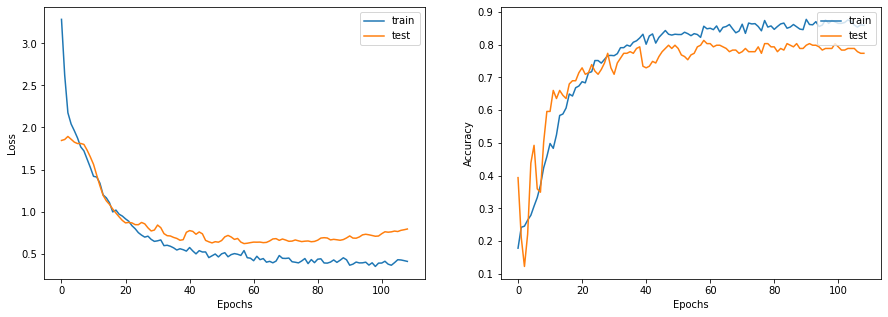

In [30]:
display_learning_curves(history)

In [31]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 74.83%


In [32]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")

In [33]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Instance 1:
- Case_Based: 21.16%
- Genetic_Algorithms: 4.75%
- Neural_Networks: 30.64%
- Probabilistic_Methods: 6.99%
- Reinforcement_Learning: 13.26%
- Rule_Learning: 3.1%
- Theory: 20.09%
Instance 2:
- Case_Based: 0.55%
- Genetic_Algorithms: 6.46%
- Neural_Networks: 85.38%
- Probabilistic_Methods: 5.13%
- Reinforcement_Learning: 0.85%
- Rule_Learning: 0.36%
- Theory: 1.27%
Instance 3:
- Case_Based: 11.9%
- Genetic_Algorithms: 8.72%
- Neural_Networks: 61.98%
- Probabilistic_Methods: 8.64%
- Reinforcement_Learning: 1.45%
- Rule_Learning: 2.99%
- Theory: 4.31%
Instance 4:
- Case_Based: 2.63%
- Genetic_Algorithms: 6.36%
- Neural_Networks: 56.03%
- Probabilistic_Methods: 14.6%
- Reinforcement_Learning: 2.47%
- Rule_Learning: 2.05%
- Theory: 15.85%
Instance 5:
- Case_Based: 0.62%
- Genetic_Algorithms: 0.72%
- Neural_Networks: 3.11%
- Probabilistic_Methods: 90.89%
- Reinforcement_Learning: 0.87%
- Rule_Learning: 2.12%
- Theory: 1.68%
Instance 6:
- Case_Based: 47.58%
- Genetic_Algorithms: 2.

In [34]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 5429)
Nodes shape: (2708, 1433)


/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_52806/2468639763.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


In [100]:
node_features

<tf.Tensor: shape=(2708, 1433), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [35]:
y_train.shape

(1349,)

In [36]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)
            
    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        print("num_nodes: ",num_nodes)
        print("neighbour_messages.shape: ",neighbour_messages.shape)
        print("neighbour_messages: ",neighbour_messages)
        print("node_indices.shape: ",node_indices.shape)
        print("node_indices: ",node_indices)
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")
        print("aggregated_message: ",aggregated_message.shape)
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        print("h.shape: ",h.shape)
        node_embeddings = self.update_fn(h)
        print("h.shape after update: ",h.shape )
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        print("node_repesentations: ",node_repesentations)
        print("node_repesentations shape: ",node_repesentations.shape)
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)
        print("neighbour_repesentations: ",neighbour_repesentations)
        print("neighbour_repesentations shape: ",neighbour_repesentations.shape)
        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [37]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        print("Initial x: ",x.shape)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        print("x1: ",x1.shape)
        print("1st conv x: ",x.shape)
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        print("x2: ",x2.shape)
        print("2nd conv x: ",x.shape)
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [38]:
x_train = train_data.paper_id.to_numpy()

In [39]:
x_train

array([1886, 1034, 2247, ..., 2259,  111,  570])

In [40]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1]))

gnn_model.summary()

Initial x:  (2708, 32)
node_repesentations:  tf.Tensor(
[[-0.00484795 -0.0559248   0.02102095 ...  0.02540728 -0.02054118
  -0.05268823]
 [ 0.06826943 -0.0219587   0.11286195 ...  0.03166911  0.02849369
  -0.07039548]
 [ 0.01693402 -0.01591313  0.00962231 ...  0.01152     0.02034927
  -0.03527375]
 ...
 [ 0.02017046  0.06053612 -0.01477915 ... -0.02691436  0.00120134
   0.01130981]
 [ 0.11886419  0.10269045  0.04358207 ...  0.14887173  0.01367483
   0.0179258 ]
 [ 0.0258988   0.06000807 -0.01415087 ...  0.10354127 -0.00742902
  -0.01395308]], shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  tf.Tensor(
[[-0.00484795 -0.0559248   0.02102095 ...  0.02540728 -0.02054118
  -0.05268823]
 [-0.00484795 -0.0559248   0.02102095 ...  0.02540728 -0.02054118
  -0.05268823]
 [-0.00484795 -0.0559248   0.02102095 ...  0.02540728 -0.02054118
  -0.05268823]
 ...
 [ 0.00083064  0.04273793 -0.01073588 ...  0.01225821 -0.03048003
  -0.01829925]
 [-0.0309478

In [41]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
Initial x:  (2708, 32)
node_repesentations:  Tensor("gnn_model/preprocess/dense_11/Gelu/mul_1:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("gnn_model/graph_conv1/GatherV2:0", shape=(5429, 32), dtype=float32)
neighbour_repesentations shape:  (5429, 32)
num_nodes:  Tensor("gnn_model/graph_conv1/add:0", shape=(), dtype=int64)
neighbour_messages.shape:  (5429, 32)
neighbour_messages:  Tensor("gnn_model/graph_conv1/mul:0", shape=(5429, 32), dtype=float32)
node_indices.shape:  (5429,)
node_indices:  Tensor("gnn_model/graph_conv1/strided_slice:0", shape=(5429,), dtype=int64)
aggregated_message:  (2708, 32)
h.shape:  (2708, 64)
h.shape after update:  (2708, 64)
x1:  (2708, 32)
1st conv x:  (2708, 32)
node_repesentations:  Tensor("gnn_model/add:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("gnn_model/graph_conv2/GatherV2:0", shape=(5429, 32), dtype=float32

Epoch 29/300
5/5 [==============================] - 1s 131ms/step - loss: 1.2107 - acc: 0.5454 - val_loss: 1.0021 - val_acc: 0.6601
Epoch 30/300
5/5 [==============================] - 1s 230ms/step - loss: 1.1396 - acc: 0.5812 - val_loss: 1.0820 - val_acc: 0.6552
Epoch 31/300
5/5 [==============================] - 1s 104ms/step - loss: 1.0923 - acc: 0.5855 - val_loss: 1.4361 - val_acc: 0.6207
Epoch 32/300
5/5 [==============================] - 0s 99ms/step - loss: 1.0901 - acc: 0.6065 - val_loss: 1.4923 - val_acc: 0.5911
Epoch 33/300
5/5 [==============================] - 1s 122ms/step - loss: 1.0645 - acc: 0.5916 - val_loss: 1.5514 - val_acc: 0.5813
Epoch 34/300
5/5 [==============================] - 0s 95ms/step - loss: 1.0747 - acc: 0.5934 - val_loss: 1.4964 - val_acc: 0.5911
Epoch 35/300
5/5 [==============================] - 0s 92ms/step - loss: 1.0650 - acc: 0.6195 - val_loss: 1.6842 - val_acc: 0.5714
Epoch 36/300
5/5 [==============================] - 0s 95ms/step - loss: 1.0337

5/5 [==============================] - 0s 97ms/step - loss: 0.5444 - acc: 0.8220 - val_loss: 0.8389 - val_acc: 0.7833
Epoch 92/300
5/5 [==============================] - 0s 99ms/step - loss: 0.5456 - acc: 0.8168 - val_loss: 0.8031 - val_acc: 0.7931
Epoch 93/300
5/5 [==============================] - 0s 98ms/step - loss: 0.5701 - acc: 0.8098 - val_loss: 0.7235 - val_acc: 0.7980
Epoch 94/300
5/5 [==============================] - 0s 98ms/step - loss: 0.5397 - acc: 0.8211 - val_loss: 0.6924 - val_acc: 0.7833
Epoch 95/300
5/5 [==============================] - 0s 100ms/step - loss: 0.5165 - acc: 0.8464 - val_loss: 0.7444 - val_acc: 0.7488
Epoch 96/300
5/5 [==============================] - 1s 100ms/step - loss: 0.4754 - acc: 0.8412 - val_loss: 0.7181 - val_acc: 0.7537
Epoch 97/300
5/5 [==============================] - 0s 100ms/step - loss: 0.5311 - acc: 0.8246 - val_loss: 0.7050 - val_acc: 0.7833
Epoch 98/300
5/5 [==============================] - 0s 101ms/step - loss: 0.5815 - acc: 0.802

Epoch 153/300
5/5 [==============================] - 1s 110ms/step - loss: 0.4236 - acc: 0.8613 - val_loss: 0.4810 - val_acc: 0.8424
Epoch 154/300
5/5 [==============================] - 1s 118ms/step - loss: 0.4215 - acc: 0.8621 - val_loss: 0.4914 - val_acc: 0.8473
Epoch 155/300
5/5 [==============================] - 1s 105ms/step - loss: 0.3736 - acc: 0.8831 - val_loss: 0.5192 - val_acc: 0.8227
Epoch 156/300
5/5 [==============================] - 1s 106ms/step - loss: 0.4221 - acc: 0.8586 - val_loss: 0.5066 - val_acc: 0.8374
Epoch 157/300
5/5 [==============================] - 1s 122ms/step - loss: 0.4803 - acc: 0.8534 - val_loss: 0.5144 - val_acc: 0.8473
Epoch 158/300
5/5 [==============================] - 1s 109ms/step - loss: 0.4310 - acc: 0.8691 - val_loss: 0.5492 - val_acc: 0.8325
Epoch 159/300
5/5 [==============================] - 1s 105ms/step - loss: 0.4081 - acc: 0.8674 - val_loss: 0.5262 - val_acc: 0.8571
Epoch 160/300
5/5 [==============================] - 1s 113ms/step - 

5/5 [==============================] - 1s 128ms/step - loss: 0.3603 - acc: 0.8839 - val_loss: 0.6263 - val_acc: 0.8325
Epoch 215/300
5/5 [==============================] - 1s 117ms/step - loss: 0.3745 - acc: 0.8927 - val_loss: 0.6309 - val_acc: 0.8276
Epoch 216/300
5/5 [==============================] - 1s 121ms/step - loss: 0.3373 - acc: 0.8927 - val_loss: 0.6682 - val_acc: 0.8177
Epoch 217/300
5/5 [==============================] - 1s 181ms/step - loss: 0.3824 - acc: 0.8778 - val_loss: 0.6718 - val_acc: 0.8374
Epoch 218/300
5/5 [==============================] - 1s 221ms/step - loss: 0.3556 - acc: 0.8848 - val_loss: 0.6472 - val_acc: 0.8276
Epoch 219/300
5/5 [==============================] - 1s 162ms/step - loss: 0.3317 - acc: 0.8927 - val_loss: 0.5979 - val_acc: 0.8325
Epoch 220/300
5/5 [==============================] - 1s 130ms/step - loss: 0.3464 - acc: 0.8909 - val_loss: 0.5679 - val_acc: 0.8621
Epoch 221/300
5/5 [==============================] - 1s 138ms/step - loss: 0.3445 -

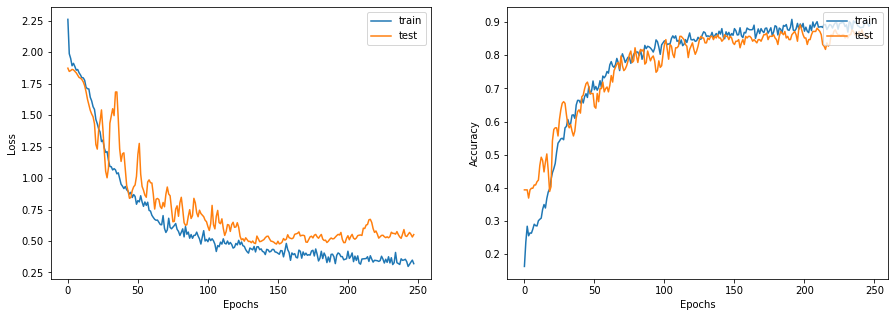

In [42]:
display_learning_curves(history)

In [43]:
!ls

GNNKeras.ipynb           caloD3PD_from_tier0.root trackML.ipynb
ML_01.ipynb              datasets
Untitled.ipynb           my_env


In [46]:
import onnx

In [47]:
import keras2onnx

AttributeError: module 'tensorflow.python.keras' has no attribute 'applications'

In [48]:
saved_model_path = "./saved_gnn"

In [49]:
keras.experimental.export_saved_model(gnn_model, saved_model_path)

AttributeError: module 'keras.api._v2.keras.experimental' has no attribute 'export_saved_model'

In [50]:
!mkdir -p saved_model

In [51]:
!ls

GNNKeras.ipynb           caloD3PD_from_tier0.root saved_model
ML_01.ipynb              datasets                 trackML.ipynb
Untitled.ipynb           my_env


In [52]:
gnn_model.save('saved_model/my_model')

Initial x:  (2708, 32)
node_repesentations:  Tensor("gnn_model/preprocess/dense_11/Gelu/mul_1:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("gnn_model/graph_conv1/GatherV2:0", shape=(5429, 32), dtype=float32)
neighbour_repesentations shape:  (5429, 32)
num_nodes:  Tensor("gnn_model/graph_conv1/add:0", shape=(), dtype=int64)
neighbour_messages.shape:  (5429, 32)
neighbour_messages:  Tensor("gnn_model/graph_conv1/mul:0", shape=(5429, 32), dtype=float32)
node_indices.shape:  (5429,)
node_indices:  Tensor("gnn_model/graph_conv1/strided_slice:0", shape=(5429,), dtype=int64)
aggregated_message:  (2708, 32)
h.shape:  (2708, 64)
h.shape after update:  (2708, 64)
x1:  (2708, 32)
1st conv x:  (2708, 32)
node_repesentations:  Tensor("gnn_model/add:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("gnn_model/graph_conv2/GatherV2:0", shape=(5429, 32), dtype=float32)
neighbour_

2022-08-18 15:51:27.361304: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


node_repesentations:  Tensor("inputs/0:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("GatherV2:0", shape=(5429, 32), dtype=float32)
neighbour_repesentations shape:  (5429, 32)
num_nodes:  Tensor("add:0", shape=(), dtype=int64)
neighbour_messages.shape:  (5429, 32)
neighbour_messages:  Tensor("mul:0", shape=(5429, 32), dtype=float32)
node_indices.shape:  (5429,)
node_indices:  Tensor("strided_slice:0", shape=(5429,), dtype=int64)
aggregated_message:  (None, 32)
h.shape:  (2708, 64)
h.shape after update:  (2708, 64)
node_repesentations:  Tensor("inputs/0:0", shape=(2708, 32), dtype=float32)
node_repesentations shape:  (2708, 32)
neighbour_repesentations:  Tensor("GatherV2:0", shape=(5429, 32), dtype=float32)
neighbour_repesentations shape:  (5429, 32)
num_nodes:  Tensor("add:0", shape=(), dtype=int64)
neighbour_messages.shape:  (5429, 32)
neighbour_messages:  Tensor("mul:0", shape=(5429, 32), dtype=float32)
node_indices.shap

In [53]:
!ls

GNNKeras.ipynb           caloD3PD_from_tier0.root saved_model
ML_01.ipynb              datasets                 trackML.ipynb
Untitled.ipynb           my_env


In [54]:
!ls saved_model

my_model


In [55]:
!ls saved_model/my_model

assets            keras_metadata.pb saved_model.pb    variables


In [56]:
from tensorflow.python.keras import backend as K

In [57]:
import keras2onnx

AttributeError: module 'tensorflow.python.keras' has no attribute 'applications'

In [58]:
import numpy as np
import onnxruntime as ort

In [59]:
!ls saved_model/my_model

assets            saved_model.onnx  variables
keras_metadata.pb saved_model.pb


In [60]:
sess_ort = ort.InferenceSession("./saved_model/my_model/saved_model.onnx")

In [63]:
input_name = sess_ort.get_inputs()[1].name
print("input name", input_name)
input_shape = sess_ort.get_inputs()[1].shape
print("input shape", input_shape)
input_type = sess_ort.get_inputs()[1].type
print("input type", input_type)

IndexError: list index out of range

In [62]:
output_name = sess_ort.get_outputs()[0].name
print("output_name", output_name)
output_shape = sess_ort.get_outputs()[0].shape
print("output shape", output_shape)
output_type = sess_ort.get_outputs()[0].type
print("output type", output_type)

output_name output_1
output shape [1, 7]
output type tensor(float)
